<div style="text-align: center;">
    <h1 style="font-size:50px">DenseNet121</h1>
</div>
<h1>Objective</h1>
<p style="font-size:15px;line-height: 1.5;">The objective of this project is to develop a deep learning model, specifically DenseNet121, that can accurately classify images into one of ten classes based on their visual features. The ten classes in the CIFAR-10 dataset are:</p>
<ul style="font-size:15px;line-height: 1.5;">
    <li>Airplane</li>
    <li>Automobile</li>
    <li>Bird</li>
    <li>Cat</li>
    <li>Deer</li>
    <li>Dog</li>
    <li>Frog</li>
    <li>Horse</li>
    <li>Ship</li>
    <li>Truck</li>
</ul>

<p style="font-size:15px">Each class has unique visual characteristics that the model will learn to identify.</p>
<h1>Dataset</h1>
<p style="font-size:15px;line-height: 1.5;">The CIFAR-10 dataset has been used for this project. It contains 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into a training set of 50,000 images and a test set of 10,000 images.</p>
<ul style="font-size:15px;line-height: 1.5;">
    <li><strong>Features</strong>: 32x32 color images with 3 channels (RGB).</li>
    <li><strong>Target</strong>: Class label of the image (one of the 10 classes).</li>
</ul>
<h1>Approach</h1>
<ul style="font-size:15px;line-height: 1.5;">
    <li>First, the dataset is explored to understand its structure and distribution of classes.</li>
    <li>Visualization of the dataset is done to show sample images from each class.</li>
    <li>Pre-processing of the dataset includes normalization, one-hot encoding of the labels and data augmentation.</li>
    <li>The DenseNet121 model is built from scratch using TensorFlow and Keras.</li>
    <li>The model is trained on the training set and validated on the test set.</li>
    <li>Performance metrics such as accuracy and loss are evaluated and visualized for both training and testing phases.</li>
</ul>

## Loading the required libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

## Loading the CIFAR-10 Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 12s 0us/step


## Displaying images from each class

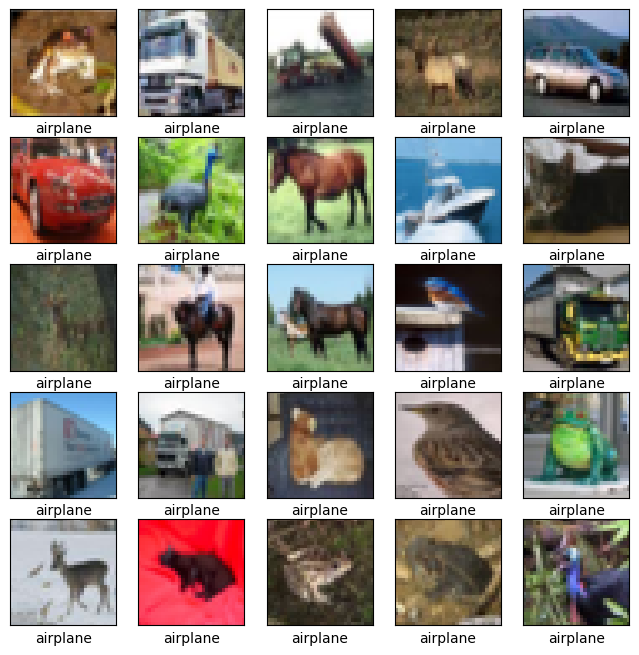

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[np.argmax(train_labels[i])])
plt.show()

## Printing the training and testing set shape

In [ ]:
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


## Pre-processing the data

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=5,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True
)

In [ ]:
train_datagen.fit(train_images)
augmented_images = []
augmented_labels = []

augmentation_factor = 2
for x_batch, y_batch in train_datagen.flow(train_images, train_labels, batch_size=len(train_images), shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) >= augmentation_factor:
        break

# Concatenate the augmented data batches
train_images = np.concatenate(augmented_images)
train_labels = np.concatenate(augmented_labels)

# Verify the shape of augmented data
print("Shape of augmented images:", train_images.shape)
print("Shape of augmented labels:", train_labels.shape)
test_images= test_images.reshape(-1, 32, 32, 3)

Shape of augmented images: (100000, 32, 32, 3)
Shape of augmented labels: (100000, 1)


### One-hot encoding of labels

In [ ]:
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

## Creating the DenseNet121 model from a scratch

In [ ]:
def dense_block(x, blocks):
    for _ in range(blocks):
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(x1)
        x = Concatenate()([x, x1])
    return x

In [ ]:
def transition_block(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 1, padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D(2)(x)
    return x

In [ ]:
def create_densenet121(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Dense blocks followed by transition layers
    x = dense_block(x, 6)
    x = transition_block(x)
    x = dense_block(x, 12)
    x = transition_block(x)
    x = dense_block(x, 24)
    x = transition_block(x)
    x = dense_block(x, 16)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
densenet121_model = create_densenet121()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
densenet121_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
densenet121_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

## Training the model

In [ ]:
history = densenet121_model.fit(
    train_images, train_labels,
    epochs=50,
    validation_data=(test_images, test_labels)
)

Epoch 1/50
3125/3125 [==============================] - 213s 53ms/step - loss: 1.5842 - accuracy: 0.4381 - val_loss: 1.4172 - val_accuracy: 0.4789
Epoch 2/50
3125/3125 [==============================] - 161s 51ms/step - loss: 1.1212 - accuracy: 0.5993 - val_loss: 1.1850 - val_accuracy: 0.5820
Epoch 3/50
3125/3125 [==============================] - 170s 54ms/step - loss: 0.9334 - accuracy: 0.6696 - val_loss: 1.1253 - val_accuracy: 0.6209
Epoch 4/50
3125/3125 [==============================] - 168s 54ms/step - loss: 0.8043 - accuracy: 0.7175 - val_loss: 1.0710 - val_accuracy: 0.6495
Epoch 5/50
3125/3125 [==============================] - 167s 54ms/step - loss: 0.6973 - accuracy: 0.7545 - val_loss: 1.2643 - val_accuracy: 0.6098
Epoch 6/50
3125/3125 [==============================] - 169s 54ms/step - loss: 0.6023 - accuracy: 0.7872 - val_loss: 0.8772 - val_accuracy: 0.7127
Epoch 7/50
3125/3125 [==============================] - 167s 53ms/step - loss: 0.5201 - accuracy: 0.8162 - val_loss: 1

## Printing the training and testing accuracy

In [ ]:
test_loss, test_acc = densenet121_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Test loss: {test_loss*100:.2f}%")

313/313 - 3s - loss: 2.0568 - accuracy: 0.7256 - 3s/epoch - 11ms/step
Test accuracy: 72.56%
Test loss: 205.68%


## Plotting the accuracy and loss

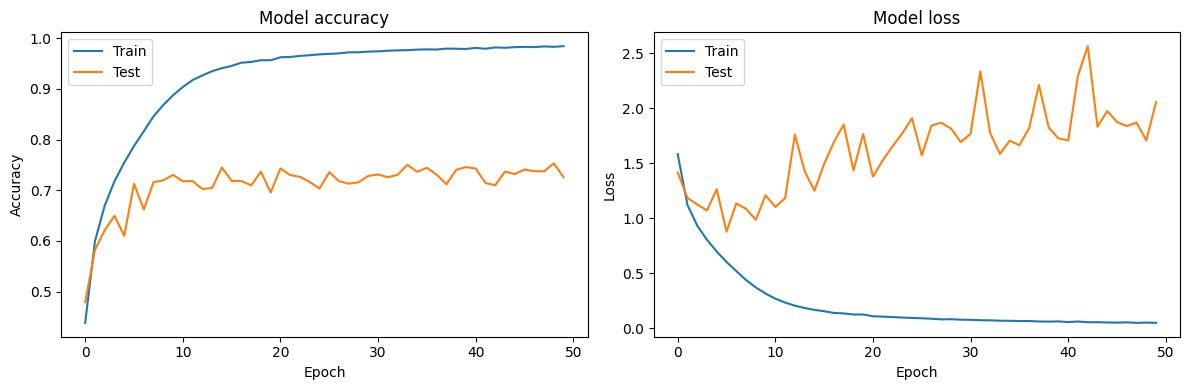

In [ ]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()